## Model metrics

In [1]:
import pandas as pd
import numpy as np
from metrics_utils import *

GZDESI/GZRings/GZCD not available from galaxy_datasets.pytorch.datasets - skipping


In [2]:
LOG_PATH = "lightning_logs"
METRICS_PATH = "../Metrics"

## Training metrics - image rotation in training

In [3]:
repeat_model_ids = ['g_lenet_cut_dataset_60',
             'lenet_cut_dataset_60',
             'resnet18_cut_dataset',
             'resnet50_cut_dataset', 
             'ce_resnet50_cut_dataset',
             'g_resnet18_cut_dataset',
             'g_resnet50_cut_dataset']

In [4]:
repeat_metrics = get_results_runs(repeat_model_ids,'val',METRICS_PATH)
repeat_metrics.head(9)

g_lenet_cut_dataset_60: Removed 5 NaNs
lenet_cut_dataset_60: Removed 5 NaNs


Model,Loss,Accuracy,ECE,C Viol
g_lenet_60,0.9028 ± 0.0070,64.32% ± 0.78%,0.1172 ± 0.0037,0.0000 ± 0.0000
lenet_60,0.9195 ± 0.0021,62.79% ± 0.20%,0.1171 ± 0.0014,0.0000 ± 0.0000
resnet18,0.6216 ± 0.0007,84.31% ± 0.17%,0.1433 ± 0.0023,0.3364 ± 0.2178
resnet50,0.6229 ± 0.0016,83.71% ± 0.40%,0.1394 ± 0.0024,0.2075 ± 0.1221
ce_resnet50,0.6152 ± 0.0009,84.57% ± 0.20%,0.1434 ± 0.0011,-0.0337 ± 0.0325
g_resnet18,0.5676 ± 0.0012,92.86% ± 0.25%,0.1909 ± 0.0014,0.2506 ± 0.0447
g_resnet50,0.5636 ± 0.0015,93.36% ± 0.39%,0.1939 ± 0.0047,-0.1780 ± 0.2598


In [5]:
repeat_metrics = get_results_runs(repeat_model_ids,'test',METRICS_PATH)
repeat_metrics.head(9)

g_lenet_cut_dataset_60: Removed 5 NaNs
lenet_cut_dataset_60: Removed 5 NaNs


Model,Loss,Accuracy,ECE,C Viol
g_lenet_60,0.4899 ± 0.0130,91.80% ± 0.15%,0.1840 ± 0.0115,0.0000 ± 0.0000
lenet_60,0.5280 ± 0.0052,91.25% ± 0.10%,0.2113 ± 0.0046,0.0000 ± 0.0000
resnet18,0.3850 ± 0.0013,94.64% ± 0.09%,0.1272 ± 0.0028,0.2137 ± 0.2867
resnet50,0.3890 ± 0.0030,94.46% ± 0.22%,0.1264 ± 0.0018,0.2507 ± 0.2260
ce_resnet50,0.3777 ± 0.0022,95.07% ± 0.13%,0.1270 ± 0.0020,0.0478 ± 0.0238
g_resnet18,0.3775 ± 0.0019,94.51% ± 0.16%,0.1078 ± 0.0028,0.4058 ± 0.1645
g_resnet50,0.3820 ± 0.0025,94.43% ± 0.14%,0.1090 ± 0.0059,0.0264 ± 0.3225


## Training metrics - no image rotation in training

In [6]:
no_rotate_repeat_model_ids = ['g_lenet_cut_dataset_60_nr',
             'lenet_cut_dataset_60_nr',
             'resnet18_cut_dataset_60_nr', 
             'resnet50_cut_dataset_60_nr', 
             'ce_resnet50_cut_dataset_60_nr', 
             'g_resnet18_cut_dataset_60_nr',
             'g_resnet50_cut_dataset_60_nr']

In [7]:
repeat_metrics = get_results_runs(no_rotate_repeat_model_ids,'val',METRICS_PATH)
repeat_metrics.head(9)

lenet_cut_dataset_60_nr: Removed 4 NaNs


Model,Loss,Accuracy,ECE,C Viol
g_lenet_60_nr,0.7821 ± 0.0351,77.54% ± 2.58%,0.1587 ± 0.0089,0.4174 ± 0.2577
lenet_60_nr,0.8562 ± 0.0341,70.61% ± 3.42%,0.1421 ± 0.0146,-0.6823 ± 0.0000
resnet18_60_nr,0.5290 ± 0.0003,98.16% ± 0.12%,0.2273 ± 0.0023,0.4963 ± 0.1710
resnet50_60_nr,0.5309 ± 0.0002,97.40% ± 0.13%,0.2195 ± 0.0031,0.7647 ± 0.3068
ce_resnet50_60_nr,0.5310 ± 0.0034,97.65% ± 0.82%,0.2232 ± 0.0066,0.2887 ± 0.0618
g_resnet18_60_nr,0.5324 ± 0.0004,98.04% ± 0.32%,0.2285 ± 0.0041,-0.3925 ± 0.1478
g_resnet50_60_nr,0.5329 ± 0.0005,97.83% ± 0.29%,0.2250 ± 0.0048,0.2535 ± 0.1361


In [8]:
repeat_metrics = get_results_runs(no_rotate_repeat_model_ids,'test',METRICS_PATH,print_latex=False)
repeat_metrics.head(9)

g_lenet_cut_dataset_60_nr: Removed 4 NaNs
lenet_cut_dataset_60_nr: Removed 5 NaNs
resnet18_cut_dataset_60_nr: Removed 1 NaNs
resnet50_cut_dataset_60_nr: Removed 1 NaNs
g_resnet18_cut_dataset_60_nr: Removed 1 NaNs


Model,Loss,Accuracy,ECE,C Viol
g_lenet_60_nr,0.5098 ± 0.0087,89.53% ± 0.28%,0.1545 ± 0.0085,0.1405 ± 0.0000
lenet_60_nr,0.5192 ± 0.0095,89.60% ± 0.60%,0.1797 ± 0.0121,0.0000 ± 0.0000
resnet18_60_nr,0.4514 ± 0.0075,92.18% ± 0.29%,0.1109 ± 0.0040,0.9351 ± 0.3880
resnet50_60_nr,0.4579 ± 0.0077,92.32% ± 0.37%,0.1201 ± 0.0060,1.3171 ± 0.4113
ce_resnet50_60_nr,0.4075 ± 0.0023,94.27% ± 0.06%,0.1171 ± 0.0063,0.0117 ± 0.0550
g_resnet18_60_nr,0.4119 ± 0.0298,93.33% ± 1.10%,0.1053 ± 0.0082,0.7135 ± 0.3542
g_resnet50_60_nr,0.4215 ± 0.0136,93.39% ± 0.83%,0.1254 ± 0.0069,-0.1103 ± 0.2283


## Testing metrics - custom 2 class predict function

In [9]:
c_repeat_model_ids = ['ce_resnet50_cut_dataset',
             'g_resnet18_cut_dataset_c',
             'g_resnet50_cut_dataset_c']

In [10]:
repeat_metrics = get_results_runs(c_repeat_model_ids,'val',METRICS_PATH)
repeat_metrics.head(9)

Model,Loss,Accuracy,ECE,C Viol
ce_resnet50,0.6152 ± 0.0009,84.57% ± 0.20%,0.1434 ± 0.0011,-0.0337 ± 0.0325
g_resnet18_c,0.5692 ± 0.0012,92.76% ± 0.21%,0.1899 ± 0.0018,-0.0188 ± 0.0374
g_resnet50_c,0.5606 ± 0.0032,93.73% ± 0.50%,0.2021 ± 0.0044,0.0091 ± 0.0293


In [11]:
repeat_metrics = get_results_runs(c_repeat_model_ids,'test',METRICS_PATH)
repeat_metrics.head(9)

g_resnet50_cut_dataset_c: Removed 1 NaNs


Model,Loss,Accuracy,ECE,C Viol
ce_resnet50,0.3777 ± 0.0022,95.07% ± 0.13%,0.1270 ± 0.0020,0.0478 ± 0.0238
g_resnet18_c,0.3766 ± 0.0045,94.40% ± 0.32%,0.1094 ± 0.0046,0.0331 ± 0.0076
g_resnet50_c,0.3805 ± 0.0042,94.42% ± 0.24%,0.1158 ± 0.0076,0.0561 ± 0.0142


## Adding dropout to CE-Resnet50

In [12]:
dropout_ids = ['ce_resnet50_cut_dataset_60_dropout','ce_resnet50_cut_dataset']

In [13]:
repeat_metrics = get_results_runs(dropout_ids,'val',METRICS_PATH,max_runs=3)
repeat_metrics.head(9)


Model,Loss,Accuracy,ECE,C Viol
ce_resnet50_60_dropout,0.6295 ± 0.0008,82.83% ± 0.02%,0.1371 ± 0.0022,0.0082 ± 0.0586
ce_resnet50,0.6153 ± 0.0009,84.57% ± 0.20%,0.1432 ± 0.0013,-0.0431 ± 0.0293


In [14]:
repeat_metrics = get_results_runs(dropout_ids,'test',METRICS_PATH,max_runs=3)
repeat_metrics.head(9)

Model,Loss,Accuracy,ECE,C Viol
ce_resnet50_60_dropout,0.3867 ± 0.0102,94.67% ± 0.63%,0.1355 ± 0.0030,0.0444 ± 0.0273
ce_resnet50,0.3776 ± 0.0029,95.09% ± 0.16%,0.1267 ± 0.0024,0.0451 ± 0.0096


## Test metrics - all models

In [15]:
all_models = ['lenet_cut_dataset_60',
             'g_lenet_cut_dataset_60',
             'resnet18_cut_dataset',
             'resnet50_cut_dataset',
             'ce_resnet50_cut_dataset',
             'g_resnet18_cut_dataset',
             'g_resnet50_cut_dataset',

             'g_lenet_cut_dataset_60_nr',
             'lenet_cut_dataset_60_nr',
             'resnet18_cut_dataset_60_nr',
             'resnet50_cut_dataset_60_nr',
             'ce_resnet50_cut_dataset_60_nr',
             'g_resnet18_cut_dataset_60_nr',
             'g_resnet50_cut_dataset_60_nr',

             'g_resnet18_cut_dataset_c',
             'g_resnet50_cut_dataset_c']
repeat_metrics = get_results_runs(all_models,'test',METRICS_PATH)
repeat_metrics.sort_values('Accuracy',ascending=False).head(len(all_models))

lenet_cut_dataset_60: Removed 5 NaNs
g_lenet_cut_dataset_60: Removed 5 NaNs
g_lenet_cut_dataset_60_nr: Removed 4 NaNs
lenet_cut_dataset_60_nr: Removed 5 NaNs
resnet18_cut_dataset_60_nr: Removed 1 NaNs
resnet50_cut_dataset_60_nr: Removed 1 NaNs
g_resnet18_cut_dataset_60_nr: Removed 1 NaNs
g_resnet50_cut_dataset_c: Removed 1 NaNs


Model,Loss,Accuracy,ECE,C Viol
ce_resnet50,0.3777 ± 0.0022,95.07% ± 0.13%,0.1270 ± 0.0020,0.0478 ± 0.0238
resnet18,0.3850 ± 0.0013,94.64% ± 0.09%,0.1272 ± 0.0028,0.2137 ± 0.2867
g_resnet18,0.3775 ± 0.0019,94.51% ± 0.16%,0.1078 ± 0.0028,0.4058 ± 0.1645
resnet50,0.3890 ± 0.0030,94.46% ± 0.22%,0.1264 ± 0.0018,0.2507 ± 0.2260
g_resnet50,0.3820 ± 0.0025,94.43% ± 0.14%,0.1090 ± 0.0059,0.0264 ± 0.3225
g_resnet50_c,0.3805 ± 0.0042,94.42% ± 0.24%,0.1158 ± 0.0076,0.0561 ± 0.0142
g_resnet18_c,0.3766 ± 0.0045,94.40% ± 0.32%,0.1094 ± 0.0046,0.0331 ± 0.0076
ce_resnet50_60_nr,0.4075 ± 0.0023,94.27% ± 0.06%,0.1171 ± 0.0063,0.0117 ± 0.0550
g_resnet50_60_nr,0.4215 ± 0.0136,93.39% ± 0.83%,0.1254 ± 0.0069,-0.1103 ± 0.2283
g_resnet18_60_nr,0.4119 ± 0.0298,93.33% ± 1.10%,0.1053 ± 0.0082,0.7135 ± 0.3542


## Final models

In [16]:
all_models = ['lenet_cut_dataset_60',
             'g_lenet_cut_dataset_60',
             'resnet18_cut_dataset',
             'resnet50_cut_dataset',
             'ce_resnet50_cut_dataset',
             'g_resnet18_cut_dataset',
             'g_resnet50_cut_dataset',
             'g_resnet18_cut_dataset_c',
             'g_resnet50_cut_dataset_c']
repeat_metrics = get_results_runs(all_models,'test',METRICS_PATH,print_latex=False)
repeat_metrics.sort_values('Accuracy',ascending=False).head(len(all_models))

lenet_cut_dataset_60: Removed 5 NaNs
g_lenet_cut_dataset_60: Removed 5 NaNs
g_resnet50_cut_dataset_c: Removed 1 NaNs


Model,Loss,Accuracy,ECE,C Viol
ce_resnet50,0.3777 ± 0.0022,95.07% ± 0.13%,0.1270 ± 0.0020,0.0478 ± 0.0238
resnet18,0.3850 ± 0.0013,94.64% ± 0.09%,0.1272 ± 0.0028,0.2137 ± 0.2867
g_resnet18,0.3775 ± 0.0019,94.51% ± 0.16%,0.1078 ± 0.0028,0.4058 ± 0.1645
resnet50,0.3890 ± 0.0030,94.46% ± 0.22%,0.1264 ± 0.0018,0.2507 ± 0.2260
g_resnet50,0.3820 ± 0.0025,94.43% ± 0.14%,0.1090 ± 0.0059,0.0264 ± 0.3225
g_resnet50_c,0.3805 ± 0.0042,94.42% ± 0.24%,0.1158 ± 0.0076,0.0561 ± 0.0142
g_resnet18_c,0.3766 ± 0.0045,94.40% ± 0.32%,0.1094 ± 0.0046,0.0331 ± 0.0076
g_lenet_60,0.4899 ± 0.0130,91.80% ± 0.15%,0.1840 ± 0.0115,0.0000 ± 0.0000
lenet_60,0.5280 ± 0.0052,91.25% ± 0.10%,0.2113 ± 0.0046,0.0000 ± 0.0000


## Validation accuracy and loss graphs (default models)

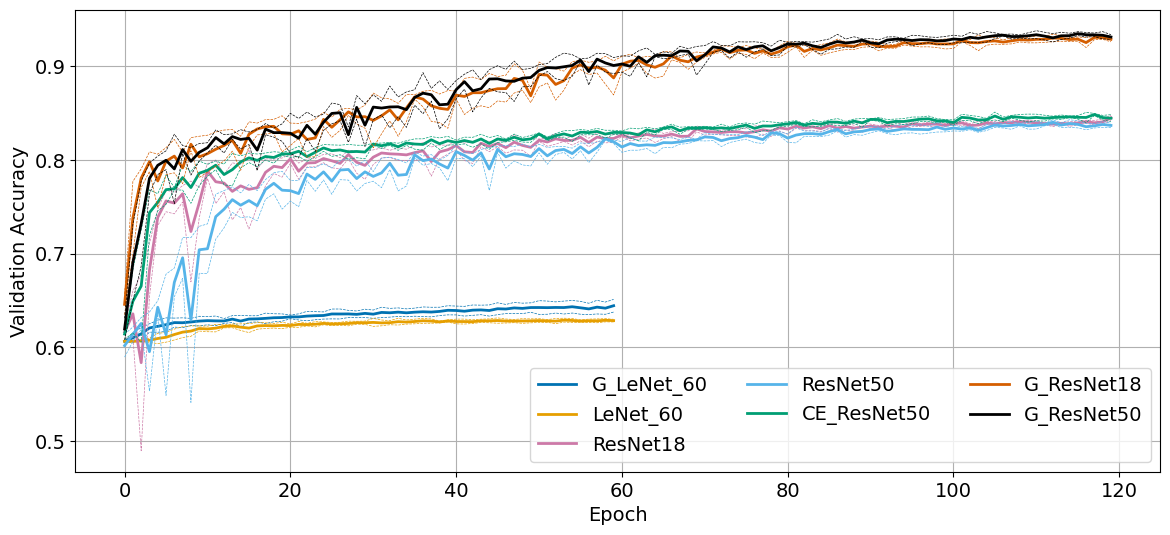

In [69]:
#plot_combined_metrics_run(repeat_model_ids,'val_loss','Validation Loss',METRICS_PATH,2)
plot_combined_metrics(repeat_model_ids,'val_acc','Validation Accuracy',METRICS_PATH)

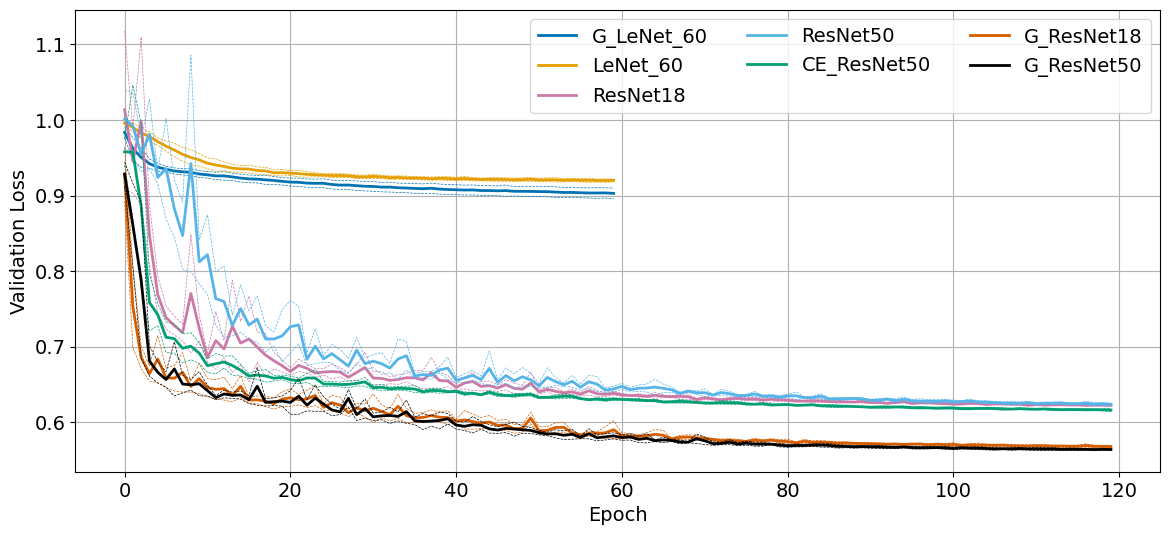

In [70]:
plot_combined_metrics(repeat_model_ids,'val_loss','Validation Loss',METRICS_PATH,l_loc="upper right")

## Predictions on DESI dataset

In [71]:
model_ids = ['resnet18_cut_dataset',
             'resnet50_cut_dataset',
            'ce_resnet50_cut_dataset',
            'g_resnet18_cut_dataset',
            'g_resnet50_cut_dataset',]
            #'g_resnet18_cut_dataset_c',
            #'g_resnet50_cut_dataset_c']

repeat_metrics = get_predict_results_runs(model_ids,5,METRICS_PATH,errors=True)
repeat_metrics.head(6)

Model,ACW,CW,Other,S/Z Ratio,C Viol
resnet18,119515 (1.4%) ± 6911,108011 (1.3%) ± 2279,8384134 (97.4%) ± 5022,1.11 ± 0.08,23.92 ± 18.81
resnet50,130157 (1.5%) ± 5087,132413 (1.5%) ± 11446,8349090 (97.0%) ± 13118,0.99 ± 0.10,-3.98 ± 23.79
ce_resnet50,111952 (1.3%) ± 2765,112272 (1.3%) ± 2587,8387436 (97.4%) ± 5348,1.00 ± 0.00,-0.68 ± 0.55
g_resnet18,133378 (1.5%) ± 10019,117627 (1.4%) ± 2564,8360655 (97.1%) ± 8946,1.14 ± 0.10,31.07 ± 23.17
g_resnet50,129642 (1.5%) ± 7201,118142 (1.4%) ± 2634,8363876 (97.1%) ± 7873,1.10 ± 0.06,22.93 ± 14.73


In [73]:
model_ids2 = ['g_resnet18_cut_dataset_c',
            'g_resnet50_cut_dataset_c']

repeat_metrics = get_predict_results_runs(model_ids2,1,METRICS_PATH,errors=False) #Increase max runs to 5
repeat_metrics.head(6)

Model,ACW,CW,Other,S/Z Ratio,C Viol
g_resnet18_c,42784 (1.7%) ± 0,43254 (1.7%) ± 0,2497460 (96.7%) ± 0,0.99 ± 0.00,-1.60 ± 0.00
g_resnet50_c,28724 (1.7%) ± 0,29126 (1.7%) ± 0,1664482 (96.6%) ± 0,0.99 ± 0.00,-1.67 ± 0.00


## Preserving chirality violation of test dataset when predicting

In [23]:
model_ids = [#'resnet18_cut_dataset_60_nr',
            #'resnet50_cut_dataset_60_nr',
    
            'resnet18_cut_dataset',
            'resnet50_cut_dataset',

            #'g_resnet18_cut_dataset_60_nr',
            #'g_resnet50_cut_dataset_60_nr',
            'g_resnet18_cut_dataset',
            'g_resnet50_cut_dataset',
              
            #'g_resnet18_cut_dataset_60_cnr',
            #'g_resnet50_cut_dataset_60_cnr',
            'g_resnet18_cut_dataset_c',
            'g_resnet50_cut_dataset_c',
            'ce_resnet50_cut_dataset']
            
chirality_list = [-12,-9,-6,-3,0,3,6,9,12]
cviol_table = get_predict_results_runs_cviol(model_ids,chirality_list,METRICS_PATH)
#cviol_table.head(5)

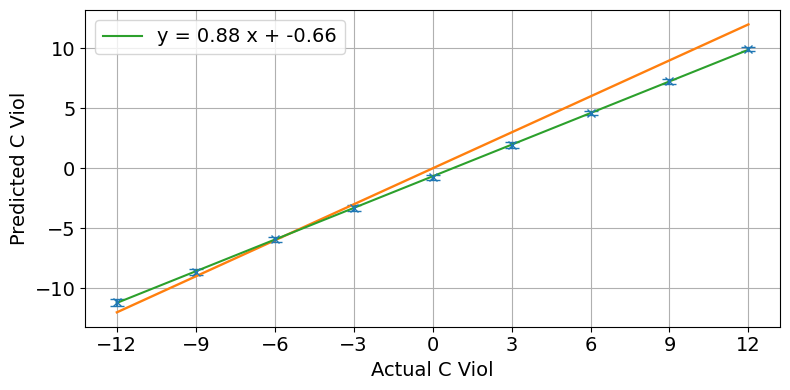

In [24]:
id = 'g_resnet50_cut_dataset_c'
plot_cviols(get_predict_results_runs_cviol([id],chirality_list,METRICS_PATH),[id],chirality_list,title=False,dims=(8,4))

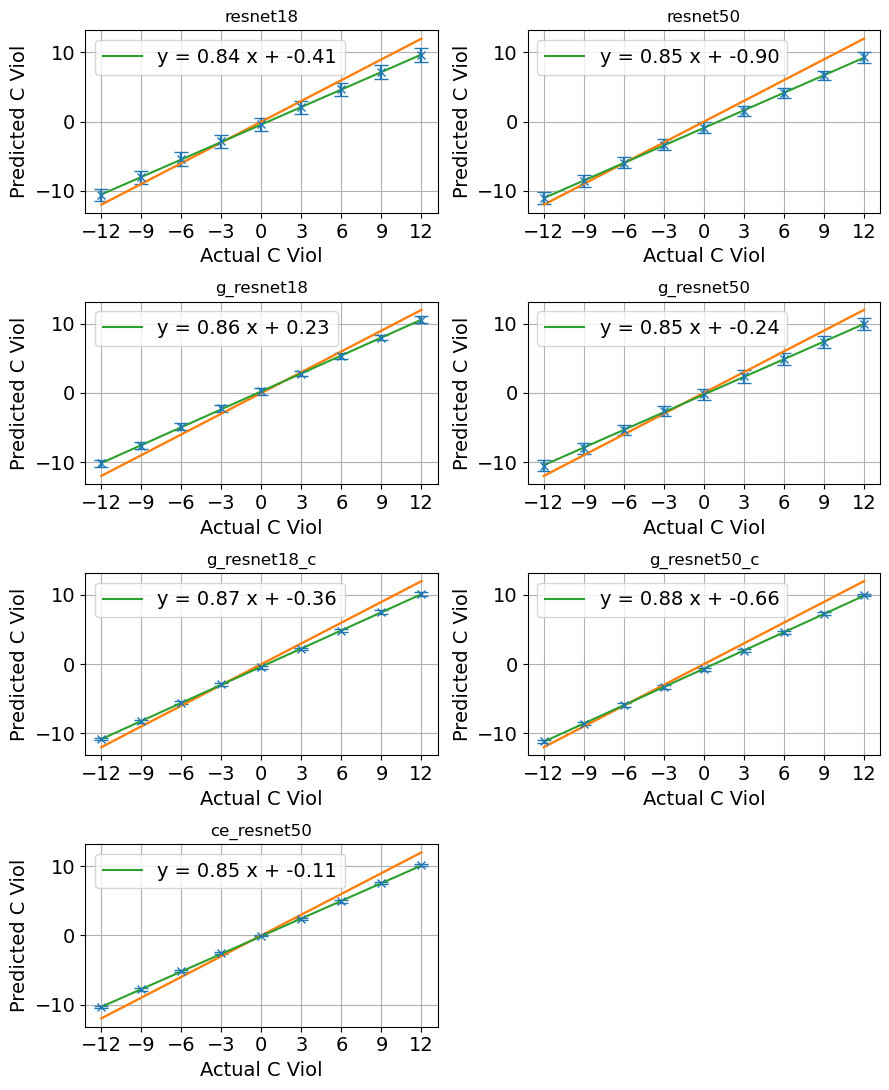

In [25]:
plot_cviols(cviol_table,model_ids,chirality_list)

In [26]:
#plot_spiral_nums(cviol_table,model_ids,chirality_list)

In [27]:
def get_total_spirals(repeat_metrics,model_ids,print_latex=False,clean_titles=True):
    spiral_metrics = pd.DataFrame(columns=["Total Spirals"],index=model_ids)
    num_actual = 2333
    for i,model in enumerate(model_ids):
        num_spirals = np.array(repeat_metrics["N Spirals"].iloc[i])#/num_actual
        num_spirals_err = np.array(repeat_metrics["N Spirals Err"].iloc[i])#/num_actual
        spiral_metrics.loc[model] = {"Total Spirals": f"{np.average(num_spirals):.0f} ({np.average(num_spirals)/num_actual:.1%}) ± {np.average(num_spirals_err):.0f}"}
    if clean_titles:
        spiral_metrics.index = spiral_metrics.index.str.replace('_cut_dataset','')
        spiral_metrics.index = spiral_metrics.index.str.replace('_repeat','')
    if print_latex:
        print(tabulate(spiral_metrics,headers='keys',tablefmt='latex'))
    
    return spiral_metrics

spiral_counts = get_total_spirals(cviol_table,model_ids,clean_titles=True,print_latex=False)
spiral_counts.head(15)

,Total Spirals
resnet18,1675 (71.8%) ± 24
resnet50,1674 (71.8%) ± 39
g_resnet18,1726 (74.0%) ± 40
g_resnet50,1686 (72.3%) ± 27
g_resnet18_c,1772 (76.0%) ± 49
g_resnet50_c,1748 (74.9%) ± 31
ce_resnet50,1692 (72.5%) ± 28


In [28]:
# def plot_spiral_nums_bar(repeat_metrics,model_ids,):
#     fig = plt.figure(figsize=(6,4))
#     total_spirals = []#np.average(repeat_metrics["N Spirals"])
#     total_spiral_errors = []#np.average(repeat_metrics["N Spirals Err"])
#     for i,model in enumerate(model_ids):
#         num_spirals = np.array(repeat_metrics["N Spirals"].iloc[i])#/num_actual
#         num_spirals_err = np.array(repeat_metrics["N Spirals Err"].iloc[i])#/num_actual
#         total_spirals.append(np.average(num_spirals))
#         total_spiral_errors.append(np.average(num_spirals_err))
#     # num_actual = 2333
#     # spiral_counts[]
#     ax = fig.add_subplot(111)
#     ax.bar(model_ids,total_spirals)
#     ax.errorbar(model_ids,total_spirals,yerr=total_spiral_errors,fmt='x')
#     ax.set_ylabel('S & Z Predicted')
#     ax.set_xlabel('Model')
#     ax.set_yticks(np.arange(0,1.1,0.1))
#     plt.tight_layout()
#     plt.show()
#plot_spiral_nums_bar(cviol_table,model_ids)

In [29]:
def plot_vote_fractions(cat,title):
    labels = ["CW","ACW","Other"]
    nice_labels = ["Clockwise Spiral","Anticlockwise Spiral","Other"]
    fig = plt.figure(figsize=(10,3))
    for i, labels in enumerate(labels):
        ax_i = fig.add_subplot(1,3,i+1)
        ax_i.hist(cat[labels],bins=10)
        ax_i.set_title(nice_labels[i])
        ax_i.set_ylim(0,1000)
        ax_i.set_xlim(0,1)
        if i==0:
            ax_i.set_ylabel("Count")
        elif i==1:
            ax_i.set_xlabel("Vote Fractions")
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

def compare_probabilities(model_ids,c_viol,max_runs=5,dataset_name="cut_test_dataset"):
    for model in model_ids:
            run = 2
            predictions = pd.read_csv(f"{METRICS_PATH}/{model}/version_{run}/{dataset_name}_CVIOL_{c_viol}_predictions.csv", names=['CW','ACW','Other'],on_bad_lines = 'skip').astype('float')
            plot_vote_fractions(predictions,model.removesuffix('_cut_dataset_repeat'))

In [30]:
#compare_probabilities(model_ids,0)